# Zillow Regression Model Notebook

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.metrics import mean_squared_error,r2_score,explained_variance_score
from math import sqrt
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import warnings
warnings.filterwarnings("ignore")
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.metrics import explained_variance_score

# modeling methods
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

import wrangle
import explore as e

#set seaborn color pallete
sns.set_palette('plasma')
pal = sns.set_palette('plasma')
print(sns.color_palette().as_hex())

['#5302a3', '#8b0aa5', '#b83289', '#db5c68', '#f48849', '#febd2a']


# Acquire Data from Database

In [2]:
df = wrangle.new_zillow_data()

## Review Summary information about df

In [3]:
df.head()

,parcel_id,tax_value,bathroom_cnt,bedroom_cnt,sqft_calculated,has_pool,fips,tax_amount,transaction_date,year_built
0,10732053,545414.0,2.0,3.0,1314.0,NaN,6037.0,6642.97,2017-08-23,1953.0
1,12688269,821706.0,3.0,5.0,3396.0,1.0,6037.0,10439.13,2017-08-23,1976.0
2,10925329,107108.0,1.0,2.0,912.0,NaN,6037.0,1262.83,2017-08-23,1939.0
3,11090259,551000.0,2.0,3.0,1901.0,NaN,6037.0,6733.37,2017-08-23,1958.0
4,12023179,719695.0,2.0,2.0,969.0,NaN,6037.0,8650.58,2017-08-23,1968.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28052 entries, 0 to 28051
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   parcel_id         28052 non-null  int64  
 1   tax_value         28052 non-null  float64
 2   bathroom_cnt      28052 non-null  float64
 3   bedroom_cnt       28052 non-null  float64
 4   sqft_calculated   28052 non-null  float64
 5   has_pool          6126 non-null   float64
 6   fips              28052 non-null  float64
 7   tax_amount        28052 non-null  float64
 8   transaction_date  28052 non-null  object 
 9   year_built        28028 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 2.1+ MB


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
parcel_id,28052.0,1.303473e+07,3.635544e+06,10711855.00,11511293.50,1.259446e+07,1.414811e+07,1.676392e+08
tax_value,28052.0,5.334663e+05,7.038357e+05,1000.00,198819.50,3.827985e+05,6.317958e+05,2.385837e+07
bathroom_cnt,28052.0,2.322080e+00,1.011810e+00,1.00,2.00,2.000000e+00,3.000000e+00,1.100000e+01
bedroom_cnt,28052.0,3.316769e+00,9.312619e-01,0.00,3.00,3.000000e+00,4.000000e+00,1.200000e+01
sqft_calculated,28052.0,1.935350e+03,9.956124e+02,240.00,1278.75,1.675000e+03,2.327000e+03,1.724500e+04
has_pool,6126.0,1.000000e+00,0.000000e+00,1.00,1.00,1.000000e+00,1.000000e+00,1.000000e+00
fips,28052.0,6.049494e+03,2.127918e+01,6037.00,6037.00,6.037000e+03,6.059000e+03,6.111000e+03
tax_amount,28052.0,6.490565e+03,8.168298e+03,51.26,2706.55,4.735315e+03,7.520577e+03,2.767978e+05
year_built,28028.0,1.963780e+03,2.310640e+01,1878.00,1950.00,1.961000e+03,1.979000e+03,2.016000e+03


In [6]:
df.shape

(28052, 10)

In [7]:
def missing_values_table(df):
    '''
    this function takes a dataframe as input and will output metrics for missing values, 
    and the percent of that column that has missing values
    '''
    # Total missing values
    mis_val = df.isnull().sum()
    
    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    
    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    
    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    
    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    
    # Print some summary information
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
        " columns that have missing values.")
        
        # Return the dataframe with missing information
    return mis_val_table_ren_columns


In [8]:
missing_values_table(df)

Your selected dataframe has 10 columns.
There are 2 columns that have missing values.


,Missing Values,% of Total Values
has_pool,21926,78.2
year_built,24,0.1


In [9]:
df = wrangle.remove_outliers(df, 1.7, ['tax_value', 'bathroom_cnt', 'sqft_calculated'])
df.head()

,parcel_id,tax_value,bathroom_cnt,bedroom_cnt,sqft_calculated,has_pool,fips,tax_amount,transaction_date,year_built
0,10732053,545414.0,2.0,3.0,1314.0,NaN,6037.0,6642.97,2017-08-23,1953.0
1,12688269,821706.0,3.0,5.0,3396.0,1.0,6037.0,10439.13,2017-08-23,1976.0
2,10925329,107108.0,1.0,2.0,912.0,NaN,6037.0,1262.83,2017-08-23,1939.0
3,11090259,551000.0,2.0,3.0,1901.0,NaN,6037.0,6733.37,2017-08-23,1958.0
4,12023179,719695.0,2.0,2.0,969.0,NaN,6037.0,8650.58,2017-08-23,1968.0


In [10]:
 # drop the duplicated rows
df = df.drop_duplicates(keep = 'first')
df.shape

(25664, 10)

In [11]:
#fill in nulls for pool with zero
df['has_pool'] = df.has_pool.fillna(value=0)

In [12]:
#verify nulls have been replaced in has_pool column 
#year_built will be imputed with mode after split
missing_values_table(df)

Your selected dataframe has 10 columns.
There are 1 columns that have missing values.


,Missing Values,% of Total Values
year_built,20,0.1


In [13]:
#convert column data types
df.fips = df.fips.astype(object)
df.year_built = df.year_built.astype(object)
df.has_pool = df.has_pool.astype(object)
df.parcel_id = df.parcel_id.astype(object)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25664 entries, 0 to 28051
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   parcel_id         25664 non-null  object 
 1   tax_value         25664 non-null  float64
 2   bathroom_cnt      25664 non-null  float64
 3   bedroom_cnt       25664 non-null  float64
 4   sqft_calculated   25664 non-null  float64
 5   has_pool          25664 non-null  object 
 6   fips              25664 non-null  object 
 7   tax_amount        25664 non-null  float64
 8   transaction_date  25664 non-null  object 
 9   year_built        25644 non-null  object 
dtypes: float64(5), object(5)
memory usage: 2.2+ MB


In [14]:
#change transaction date to datetime
df['transaction_date'] = pd.to_datetime(df.transaction_date)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25664 entries, 0 to 28051
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   parcel_id         25664 non-null  object        
 1   tax_value         25664 non-null  float64       
 2   bathroom_cnt      25664 non-null  float64       
 3   bedroom_cnt       25664 non-null  float64       
 4   sqft_calculated   25664 non-null  float64       
 5   has_pool          25664 non-null  object        
 6   fips              25664 non-null  object        
 7   tax_amount        25664 non-null  float64       
 8   transaction_date  25664 non-null  datetime64[ns]
 9   year_built        25644 non-null  object        
dtypes: datetime64[ns](1), float64(5), object(4)
memory usage: 2.2+ MB


In [16]:
df.head()

,parcel_id,tax_value,bathroom_cnt,bedroom_cnt,sqft_calculated,has_pool,fips,tax_amount,transaction_date,year_built
0,10732053,545414.0,2.0,3.0,1314.0,0.0,6037.0,6642.97,2017-08-23,1953.0
1,12688269,821706.0,3.0,5.0,3396.0,1.0,6037.0,10439.13,2017-08-23,1976.0
2,10925329,107108.0,1.0,2.0,912.0,0.0,6037.0,1262.83,2017-08-23,1939.0
3,11090259,551000.0,2.0,3.0,1901.0,0.0,6037.0,6733.37,2017-08-23,1958.0
4,12023179,719695.0,2.0,2.0,969.0,0.0,6037.0,8650.58,2017-08-23,1968.0


## Initial Univariate Exploration

In [17]:
#create df to explore
explore_df = df[['tax_value', 'bathroom_cnt', 'sqft_calculated', 'bedroom_cnt', 'has_pool', 'year_built']]

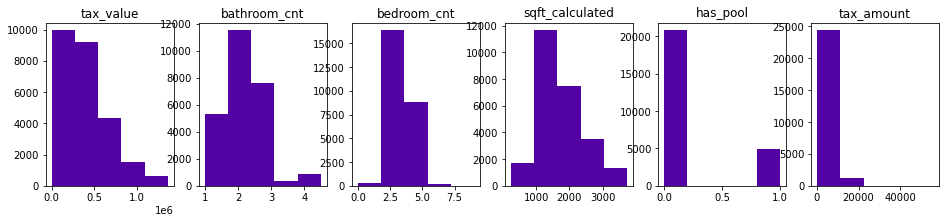

In [18]:
plt.figure(figsize=(16, 3))

# List of columns
cols = [col for col in df.columns if col not in ['fips', 'year_built', 'transaction_date', 'parcel_id']]

for i, col in enumerate(cols):

    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1 

    # Create subplot.
    plt.subplot(1, len(cols), plot_number)

    # Title with column name.
    plt.title(col)

    # Display histogram for column.
    df[col].hist(bins=5)

    # Hide gridlines.
    plt.grid(False)
    
plt.show()

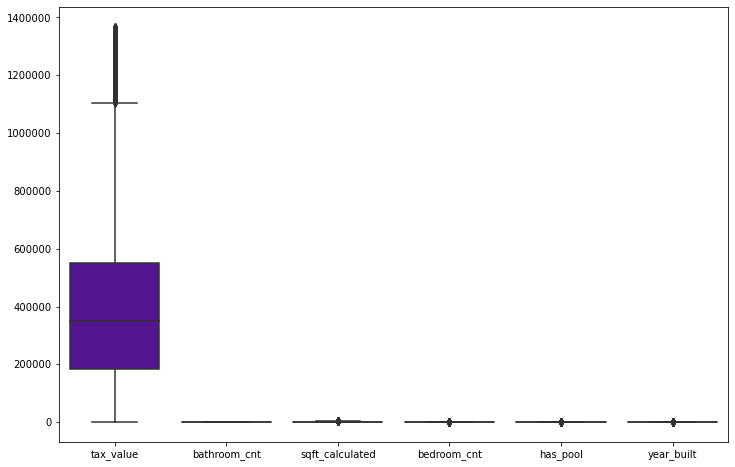

In [19]:
plt.figure(figsize=(12,8))

plt.ticklabel_format(useOffset=False, style='plain')
sns.boxplot(data=explore_df)

plt.show()

In [20]:
def remove_outliers(df, k, col_list):
    ''' remove outliers from a list of columns in a dataframe 
        and return that dataframe
    '''
    
    for col in col_list:

        q1, q3 = df[col].quantile([.25, .75])  # get quartiles
        
        iqr = q3 - q1   # calculate interquartile range
        
        upper_bound = q3 + k * iqr   # get upper bound
        lower_bound = q1 - k * iqr   # get lower bound

        # return dataframe without outliers
        
        df = df[(df[col] > lower_bound) & (df[col] < upper_bound)]
        
    return df

In [21]:
def prepare_zillow(df):
    
    """
    This function takes in the zillow dataframe and retuns the cleaned and prepped dataset
    to use when doing exploratory data analysis
    """
    
    #remove outliers
    df = remove_outliers(df, 1.7, ['tax_value', 'bathroom_cnt', 'sqft_calculated'])
    
    #convert column data types
    df.fips = df.fips.astype(object)
    df.year_built = df.year_built.astype(object)
    df.has_pool = df.has_pool.astype(object)
    df.parcel_id = df.parcel_id.astype(object)
    
    #change transaction date to datetime
    df['transaction_date'] = pd.to_datetime(df.transaction_date)
    
    #drop taxamount column
    df = df.drop(columns=['taxamount'])
    
    #split data
    train, validate, test = split_continuous(df)
    
    #impute year_built with mode
    #create imputer
    imputer = SimpleImputer(strategy='most_frequent')
    #fit to train
    imputer.fit(train[['year_built']])
    #transform data
    train[['year_built']] = imputer.transform(train[['year_built']])
    validate[['year_built']] = imputer.transform(validate[['year_built']])
    test[['year_built']] = imputer.transform(test[['year_built']])
    
    return train, validate, test

In [22]:
################ Scaler helper function ################
def tip_the_scale(train, validate, test, column_names, scaler, scaler_name):
    
    '''
    This function takes in the train validate and test dataframes, list of columns you want to scale, a scaler type,
    scaler_name
    column_names: list of columns to scale
    scaler_name, the name for the new dataframe columns
    adds columns to the train validate and test dataframes
    outputs scaler for doing inverse transforms
    ouputs a list of the new column names
    
    '''
    
    #create the scaler (input here should be scaler type used)
    mm_scaler = scaler
    
    #make empty list for return
    scaled_column_list = []
    
    #loop through columns in col names
    for col in column_names:
        
        #fit and transform to train, add to new column on train df
        train[f'{col}_{scaler_name}'] = mm_scaler.fit_transform(train[[col]]) 
        
        #df['col'].values.reshape(-1, 1)
        
        #transform cols from validate and test (only fit on train)
        validate[f'{col}_{scaler_name}']= mm_scaler.transform(validate[[col]])
        test[f'{col}_{scaler_name}']= mm_scaler.transform(test[[col]])
        
        #add new column name to the list that will get returned
        scaled_column_list.append(f'{col}_{scaler_name}')
    
    #returns scaler, and a list of column names that can be used in X_train, X_validate and X_test.
    return scaler, scaled_column_list 

In [23]:
train, validate, test = wrangle.prepare_zillow(wrangle.new_zillow_data())

train -> (14025, 9)
validate -> (6012, 9)
test -> (5010, 9)


# Scale Data -  sqft_calculated

In [24]:
scaler, scaled_columns = tip_the_scale(train, validate, test, ['sqft_calculated'], MinMaxScaler(), 'min_max')

In [25]:
#look at dataframe with new scaled sqft_calculated column
train.head()

,parcel_id,tax_value,bathroom_cnt,bedroom_cnt,sqft_calculated,has_pool,fips,transaction_date,year_built,sqft_calculated_min_max
21435,79640490,314659.0,2.5,3.0,1688.0,0.0,6059.0,2017-07-28,2002.0,0.384963
22864,13875500,286480.0,1.0,2.0,832.0,0.0,6059.0,2017-05-11,1922.0,0.143019
23570,14000171,76321.0,2.0,3.0,1648.0,0.0,6059.0,2017-06-14,1961.0,0.373657
3979,12690180,1177488.0,3.0,3.0,1735.0,0.0,6037.0,2017-07-11,1976.0,0.398248
5442,13051623,223968.0,2.0,4.0,2267.0,0.0,6037.0,2017-05-03,1975.0,0.548615


# Data Summary

## Target
tax_value
## Variables
#### Categorial variables:
- fips
- bedrooms
- bathrooms

#### Continous variables:
- sqft_calculated
- transaction_date

#### Other
- parcel_id - property identifier
- tax_amount - amount of taxes paid - removed from modeling df to prevent data leakage

# Explore

In [26]:
#create df to explore
explore_train = train[['bathroom_cnt', 'sqft_calculated_min_max', 'bedroom_cnt', 'has_pool']]

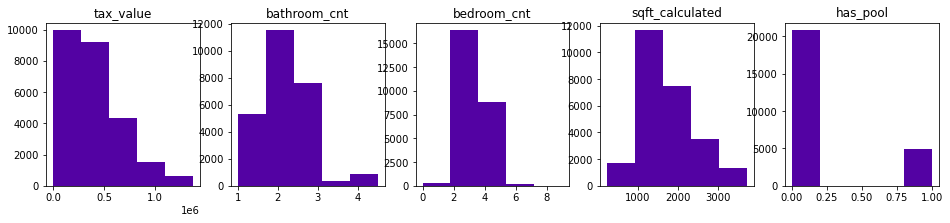

In [27]:
plt.figure(figsize=(16, 3))

# List of columns
cols = [col for col in train.columns if col not in ['fips', 'year_built', 'transaction_date', 'parcel_id', 'sqft_calculated_min_max']]

for i, col in enumerate(cols):

    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1 

    # Create subplot.
    plt.subplot(1, len(cols), plot_number)

    # Title with column name.
    plt.title(col)

    # Display histogram for column.
    df[col].hist(bins=5)

    # Hide gridlines.
    plt.grid(False)
    
plt.show()

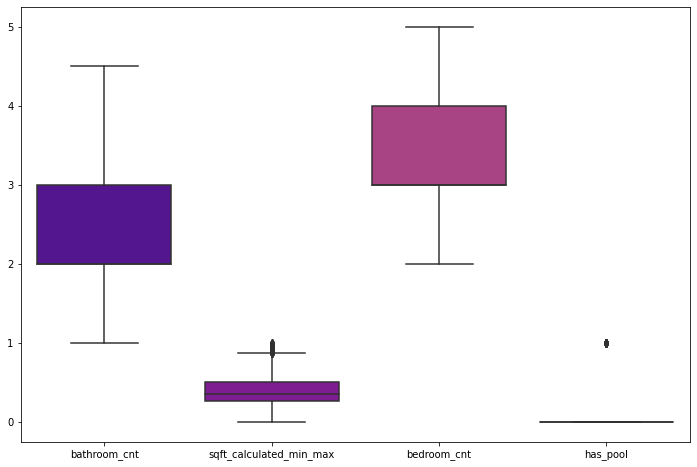

In [28]:
plt.figure(figsize=(12,8))

plt.ticklabel_format(useOffset=False, style='plain')
sns.boxplot(data=explore_train)

plt.show()

In [29]:
#create df to explore
explore_train_multi = train[['tax_value', 'bathroom_cnt', 'sqft_calculated_min_max', 'bedroom_cnt', 'has_pool']]

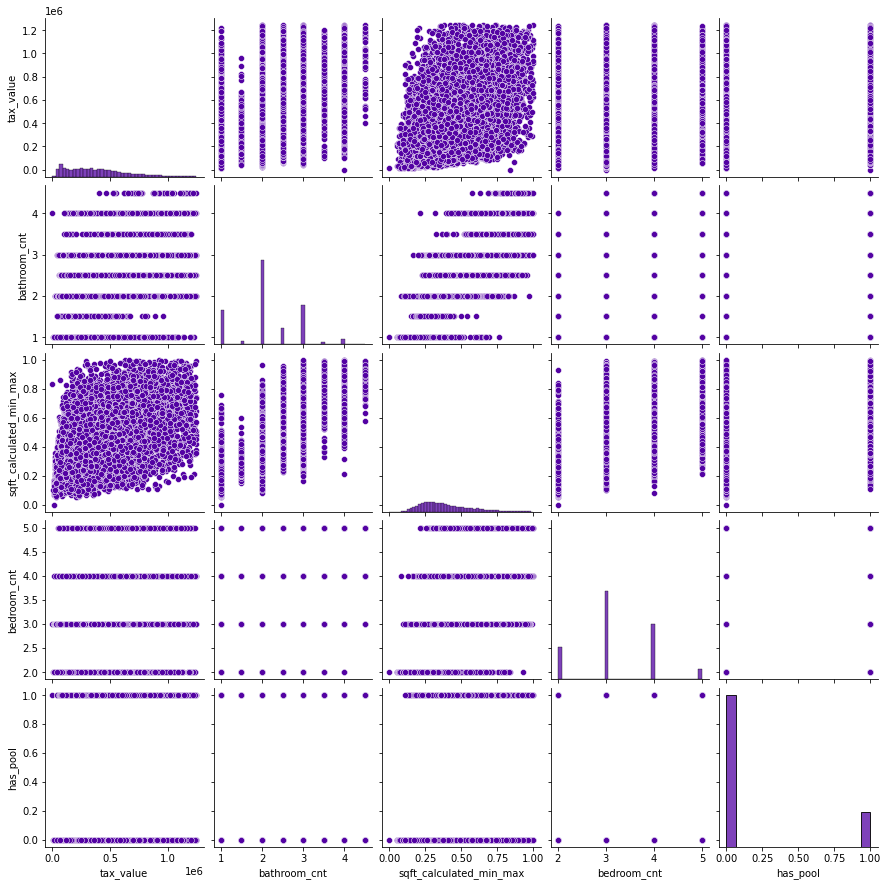

In [30]:
sns.pairplot(explore_train_multi)

Text(0.5, 1.0, 'Feature Correlation')

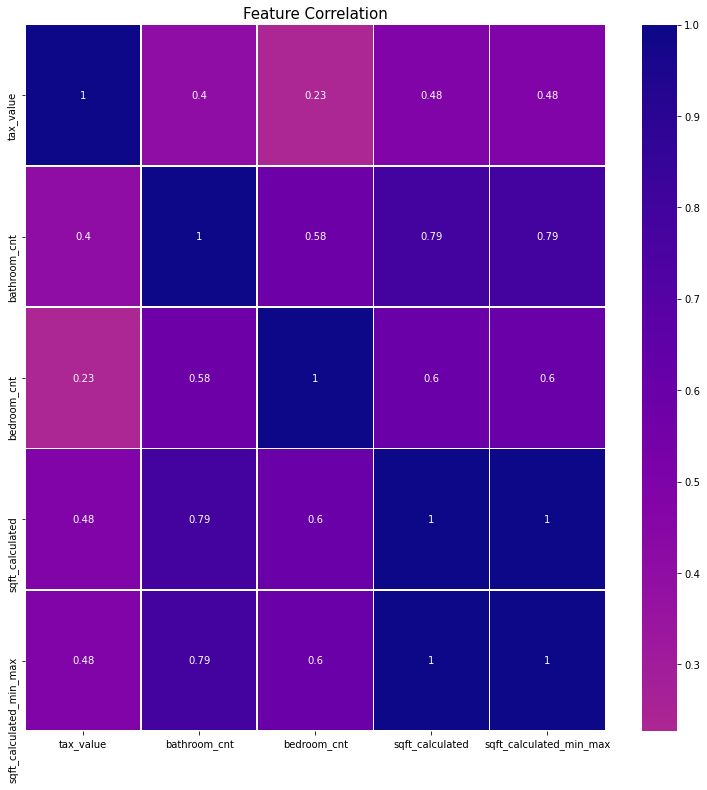

In [31]:
#correlation heat map of above
f, ax = plt.subplots(figsize=(13,13))
sns.heatmap(train.corr(), annot=True, center=0, linewidth=.5, ax=ax, cmap="plasma_r")
plt.title('Feature Correlation', fontsize=15)

<AxesSubplot:>

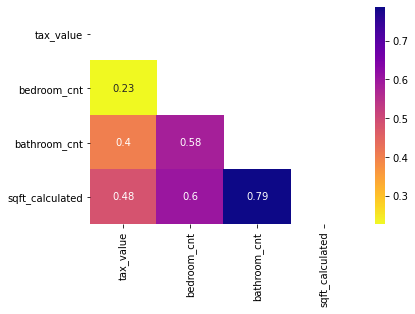

In [32]:
correlation = train[['tax_value', 'bedroom_cnt', 'bathroom_cnt', 'sqft_calculated', 'has_pool']].corr()
sns.heatmap(correlation, cmap='plasma_r', annot = True, mask = np.triu(correlation))

## Explore Takeaways:
- the bigger the house the higher the value
- bathrooms and bedrooms are also good indicators of a home value
- square feet and bathroom count have a fairly strong correlation

# Statistical Testing - Pearson R
- My initial hypothesis is that square footage and number of bathrooms are correlated with home value
- I also brought the has_pool column into the dataframe to see if there was a correlation
- I will run statistical tests on both to determine if there is a correlation

## Test One - Square Feet and Home Value
$H_{0}$: there is NOT a linear correlation between sqft_calculated and tax_value.

$H_{a}$ : there IS a significant linear correlation between sqft_calculated and tax_value.

In [33]:
n = validate.shape[0]
alpha = .05
confidence_interval = .95
degrees_of_freedom = n-2

In [34]:
corr, p = stats.pearsonr(train.sqft_calculated_min_max, train.tax_value)

if p < alpha:
    print(f'''Correlation is :{corr:.4}
p value is {p}
Yay!  We can reject our null hypothesis that sqft_calculated and tax value have no linear correlation.
There is evidence to support there is a significant linear correlation.''')
if p > alpha:
    print(f'We cannot reject the null hypothesis')

Correlation is :0.4847
p value is 0.0
Yay!  We can reject our null hypothesis that sqft_calculated and tax value have no linear correlation.
There is evidence to support there is a significant linear correlation.


## Test Two - Bathroom Count and Home Value
$H_{0}$: there is NOT a linear correlation between bathroom_count and tax_value.

$H_{a}$ : there IS a significant linear correlation between bathroom_count and tax_value.

In [35]:
corr, p = stats.pearsonr(train.sqft_calculated_min_max, train.tax_value)

if p < alpha:
    print(f'''Correlation is :{corr:.4}
p value is {p}
Yay!  We can reject our null hypothesis that the number of bathroooms and tax value have no linear correlation.
There is evidence to support there is a significant correlation between the number of bathrooms as house has and the home value.''')
if p > alpha:
    print(f'We cannot reject the null hypothesis')

Correlation is :0.4847
p value is 0.0
Yay!  We can reject our null hypothesis that the number of bathroooms and tax value have no linear correlation.
There is evidence to support there is a significant correlation between the number of bathrooms as house has and the home value.


## Test Three - Pool and Home Value
$H_{0}$: there is NOT a linear correlation between has_pool and tax_value.

$H_{a}$ : there IS a significant linear correlation between has_pool and tax_value.

In [36]:
corr, p = stats.pearsonr(train.has_pool, train.tax_value)

if p < alpha:
    print(f'''Correlation is :{corr:.4}
p value is {p}
Yay!  We can reject our null hypothesis that having a pool and tax value have no linear correlation.
There is evidence to support there is a significant correlation between having a pool and the home value.''')
if p > alpha:
    print(f'We cannot reject the null hypothesis')

Correlation is :0.1884
p value is 3.542745178495959e-112
Yay!  We can reject our null hypothesis that having a pool and tax value have no linear correlation.
There is evidence to support there is a significant correlation between having a pool and the home value.


# Modeling

In [37]:
#Establish X & y
y_train = train.tax_value
X_train = train[['bathroom_cnt', 'bedroom_cnt', 'sqft_calculated_min_max']]

y_validate = validate.tax_value
X_validate = validate[['bathroom_cnt', 'bedroom_cnt', 'sqft_calculated_min_max']]

y_test = test.tax_value
X_test = test[['bathroom_cnt', 'bedroom_cnt', 'sqft_calculated_min_max']]

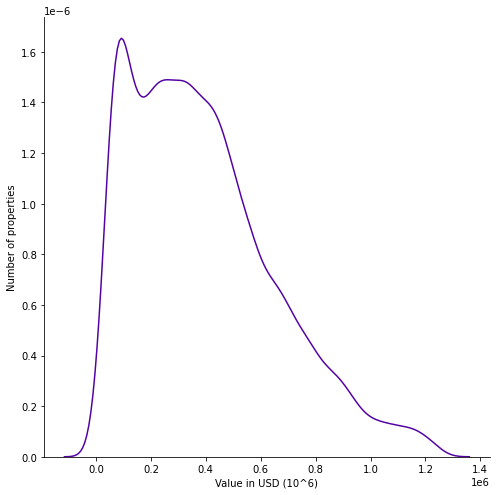

In [38]:
#plot our target
sns.displot(y_train,  kind="kde", height =7,aspect =1)
plt.xlabel("Value in USD (10^6)")
plt.ylabel("Number of properties")
plt.show()

## Create Baseline

In [39]:
# create dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

In [40]:
#create prediction columns for the train, validate, and test df
y_train['baseline_mean'] = train.tax_value.mean()
y_train['baseline_median'] = train.tax_value.median()

y_validate['baseline_mean'] = train.tax_value.mean()
y_validate['baseline_median'] = train.tax_value.median()

y_test['baseline_mean'] = train.tax_value.mean()
y_test['baseline_median'] = train.tax_value.median()

In [41]:
#Calculate RMSE of baseline_mean
rmse_train = mean_squared_error(y_train.tax_value,
                                y_train.baseline_mean) ** .5
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.baseline_mean) ** (1/2)

In [42]:
print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  261531.96 
Validate/Out-of-Sample:  268055.51


In [43]:
#Calculate RMSE of baseline_median
rmse_train = mean_squared_error(y_train.tax_value,
                                y_train.baseline_median) ** .5
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.baseline_median) ** (1/2)

In [44]:
# 4. RMSE of baseline_median
rmse_train = mean_squared_error(y_train.tax_value, y_train.baseline_median) ** .5
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.baseline_median) ** .5
print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Median
Train/In-Sample:  264869.35 
Validate/Out-of-Sample:  271443.62


## I selected mean for my baseline because the RMSE is lower.

In [45]:
#build metric_df
def make_metric_df(y, y_pred, model_name, metric_df):
    if metric_df.size ==0:
        metric_df = pd.DataFrame(data=[
            {
                'model': model_name, 
                'RMSE_validate': mean_squared_error(
                    y,
                    y_pred) ** .5,
                'r^2_validate': explained_variance_score(
                    y,
                    y_pred)
            }])
        return metric_df
    else:
        return metric_df.append(
            {
                'model': model_name, 
                'RMSE_validate': mean_squared_error(
                    y,
                    y_pred) ** .5,
                'r^2_validate': explained_variance_score(
                    y,
                    y_pred)
            }, ignore_index=True)

In [46]:
# create the metric_df as a blank dataframe
metric_df = pd.DataFrame()
# make our first entry into the metric_df with median baseline
metric_df = make_metric_df(y_train.tax_value,
                           y_train.baseline_mean,
                           'mean_baseline',
                          metric_df)

In [47]:
metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,261531.96054,0.0


## LinearRegression (OLS)
- Fit the model using X_train and the labels from y_train.
- Predict final grade for students in training sample using our model (lm).
- Evaluate using RMSE
- Repeat predictions and evaluation for validation.
- Compare RMSE train vs. validation. Overfitting?

In [48]:
y_train.head()

,tax_value,baseline_mean,baseline_median
21435,314659.0,392338.281212,350424.0
22864,286480.0,392338.281212,350424.0
23570,76321.0,392338.281212,350424.0
3979,1177488.0,392338.281212,350424.0
5442,223968.0,392338.281212,350424.0


In [49]:
#create model object
lm = LinearRegression(normalize=True)

In [50]:
# fit the model to our training data. 
lm.fit(X_train, y_train.tax_value)

LinearRegression(normalize=True)

In [51]:
#predict train
y_train['tax_value_pred_lm'] = lm.predict(X_train)

In [52]:
# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lm) ** (1/2)

# predict validate
y_validate['tax_value_pred_lm'] = lm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lm) ** (1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  227317.68405507234 
Validation/Out-of-Sample:  230982.96509145832


In [53]:
#add results to metric_df
metric_df = metric_df.append({
    'model': 'OLS Regressor', 
    'RMSE_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate.tax_value, y_validate.tax_value_pred_lm)}, ignore_index=True)

In [54]:
metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,261531.960540,0.000000
1,OLS Regressor,230982.965091,0.257483


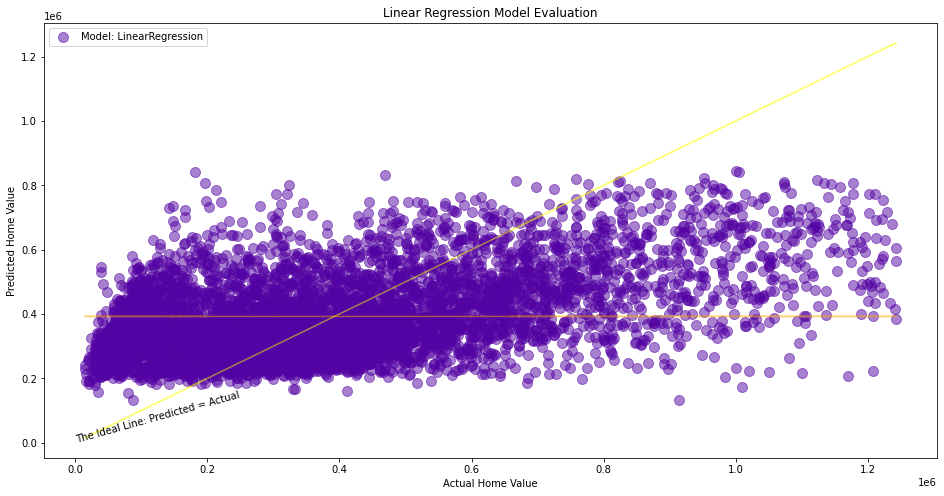

In [55]:
plt.figure(figsize=(16,8))
plt.plot(y_validate.tax_value, y_validate.baseline_mean, alpha=.5, color="orange", label='_nolegend_')
plt.plot(y_validate.tax_value, y_validate.tax_value, alpha=.5, color="yellow", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (.5, 3.5), rotation=15.5)

plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_lm, 
            alpha=.5, color="#5302a3", s=100, label="Model: LinearRegression")

plt.legend()
plt.xlabel("Actual Home Value")
plt.ylabel("Predicted Home Value")
plt.title("Linear Regression Model Evaluation")
plt.show()

## LassoLars
- Fit the model using X_train_scaled and the labels from y_train.
- Predict final grade for students in training sample using our model (lars).
- Evaluate using RMSE
- Repeat predictions and evaluation for validation.
- Compare RMSE train vs. validation. Overfitting?

In [56]:
# create the model object
lars = LassoLars(alpha=1)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series!
lars.fit(X_train, y_train.tax_value)

# predict train
y_train['tax_value_pred_lars'] = lars.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lars) ** (1/2)

# predict validate
y_validate['tax_value_pred_lars'] = lars.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lars) ** (1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Lasso + Lars
Training/In-Sample:  227317.85985385423 
Validation/Out-of-Sample:  230992.66228081452


In [57]:
metric_df = make_metric_df(y_validate.tax_value,
               y_validate.tax_value_pred_lars,
               'lasso_alpha_1',
               metric_df)

In [58]:
metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,261531.960540,0.000000
1,OLS Regressor,230982.965091,0.257483
2,lasso_alpha_1,230992.662281,0.257421


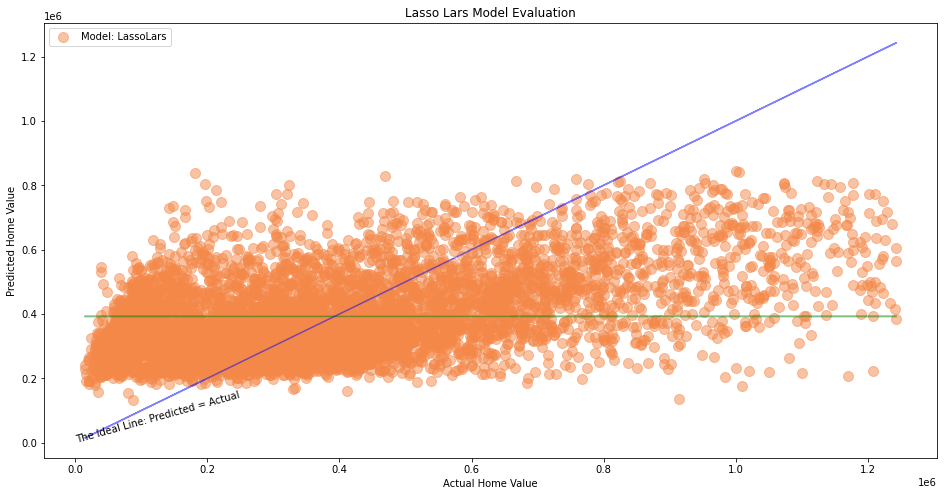

In [59]:
plt.figure(figsize=(16,8))
plt.plot(y_validate.tax_value, y_validate.baseline_mean, alpha=.5, color="green", label='_nolegend_')
plt.plot(y_validate.tax_value, y_validate.tax_value, alpha=.5, color="blue", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (.5, 3.5), rotation=15.5)

plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_lars, 
            alpha=.5, color="#f48849", s=100, label="Model: LassoLars")
plt.legend()
plt.xlabel("Actual Home Value")
plt.ylabel("Predicted Home Value")
plt.title("Lasso Lars Model Evaluation")
plt.show()

## TweedieRegressor (GLM)
- Fit the model using X_train and the labels from y_train.
- Predict final grade for students in training sample using our model (glm).
- Evaluate using RMSE
- Repeat predictions and evaluation for validation.
- Compare RMSE train vs. validation. Overfitting?

In [60]:
# create the model object
glm = TweedieRegressor(power=1, alpha=0)


# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train, y_train.tax_value)

# predict train
y_train['tax_value_pred_glm'] = glm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_glm) ** (1/2)

# predict validate
y_validate['tax_value_pred_glm'] = glm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_glm) ** (1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  227782.97292679755 
Validation/Out-of-Sample:  230658.8029030313


In [61]:
metric_df = make_metric_df(y_validate.tax_value,
               y_validate.tax_value_pred_glm,
               'glm_poisson',
               metric_df)

In [62]:
metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,261531.960540,0.000000
1,OLS Regressor,230982.965091,0.257483
2,lasso_alpha_1,230992.662281,0.257421
3,glm_poisson,230658.802903,0.259557


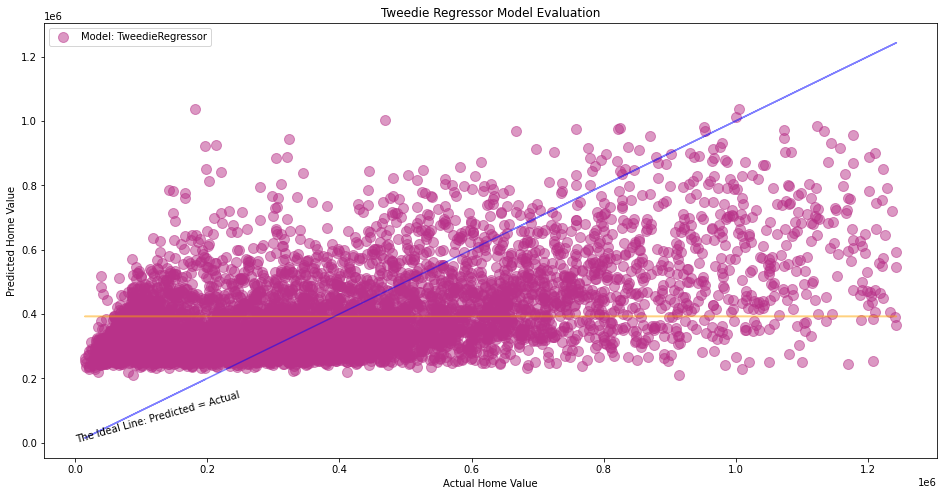

In [63]:
plt.figure(figsize=(16,8))
plt.plot(y_validate.tax_value, y_validate.baseline_mean, alpha=.5, color="orange", label='_nolegend_')
plt.plot(y_validate.tax_value, y_validate.tax_value, alpha=.5, color="blue", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (.5, 3.5), rotation=15.5)

plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_glm, 
            alpha=.5, color="#b83289", s=100, label="Model: TweedieRegressor")
plt.legend()
plt.xlabel("Actual Home Value")
plt.ylabel("Predicted Home Value")
plt.title("Tweedie Regressor Model Evaluation")
plt.show()

In [64]:
# create the model object
glm = TweedieRegressor(power=2, alpha=0)


# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train, y_train.tax_value)

# predict train
y_train['tax_value_pred_glm2'] = glm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_glm2) ** (1/2)

# predict validate
y_validate['tax_value_pred_glm2'] = glm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_glm2) ** (1/2)

print("RMSE for GLM using Tweedie, power=2 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for GLM using Tweedie, power=2 & alpha=0
Training/In-Sample:  228096.17889858337 
Validation/Out-of-Sample:  230709.92760021036


In [65]:
metric_df = make_metric_df(y_validate.tax_value,
               y_validate.tax_value_pred_glm2,
               'glm_poisson_2',
               metric_df)

In [66]:
metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,261531.960540,0.000000
1,OLS Regressor,230982.965091,0.257483
2,lasso_alpha_1,230992.662281,0.257421
3,glm_poisson,230658.802903,0.259557
4,glm_poisson_2,230709.927600,0.259259


### All Model Visualized

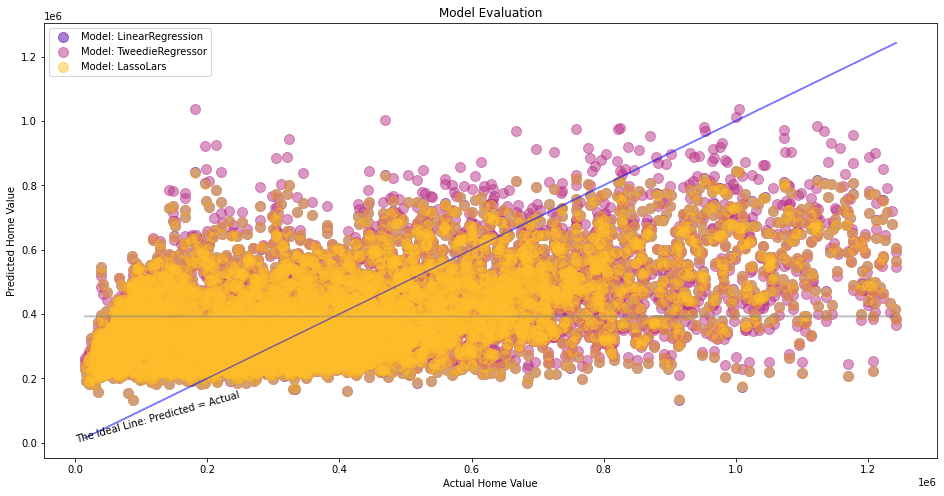

In [67]:
plt.figure(figsize=(16,8))
plt.plot(y_validate.tax_value, y_validate.baseline_mean, alpha=.5, color="gray", label='_nolegend_')
plt.plot(y_validate.tax_value, y_validate.tax_value, alpha=.5, color="blue", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (.5, 3.5), rotation=15.5)

plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_lm, 
            alpha=.5, color="#5302a3", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_glm, 
            alpha=.5, color="#b83289", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_lars, 
            alpha=.5, color="#febd2a", s=100, label="Model: LassoLars")
plt.legend()
plt.xlabel("Actual Home Value")
plt.ylabel("Predicted Home Value")
plt.title("Model Evaluation")
plt.show()

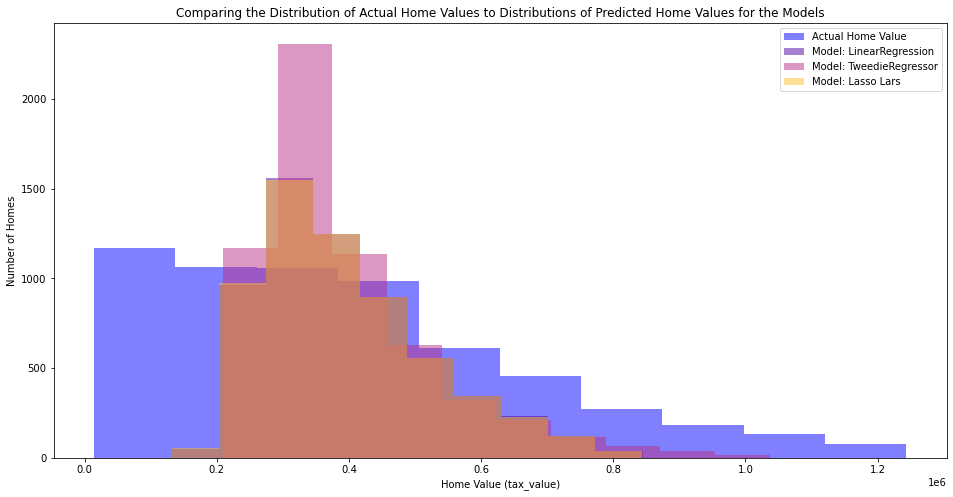

In [68]:
# plot to visualize actual vs predicted. 
plt.figure(figsize=(16,8))
plt.hist(y_validate.tax_value, color='blue', alpha=.5, label="Actual Home Value")
plt.hist(y_validate.tax_value_pred_lm, color='#5302a3', alpha=.5, label="Model: LinearRegression")
plt.hist(y_validate.tax_value_pred_glm, color='#b83289', alpha=.5, label="Model: TweedieRegressor")
plt.hist(y_validate.tax_value_pred_lars, color='#febd2a', alpha=.5, label="Model: Lasso Lars")
plt.xlabel("Home Value (tax_value)")
plt.ylabel("Number of Homes")
plt.title("Comparing the Distribution of Actual Home Values to Distributions of Predicted Home Values for the Models")
plt.legend()
plt.show()

In [69]:
metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,261531.960540,0.000000
1,OLS Regressor,230982.965091,0.257483
2,lasso_alpha_1,230992.662281,0.257421
3,glm_poisson,230658.802903,0.259557
4,glm_poisson_2,230709.927600,0.259259


## Takeaways
- My Tweedie Regressor Model preformed the best and reduced RMSE decreasing RMSE by 12%

# Tax Rate Distribution

Website for fips information
https://www.nrcs.usda.gov/wps/portal/nrcs/detail/national/home/?cid=nrcs143_013697

In [70]:
tax_df = wrangle.prep_zillow_taxrate(df)

In [71]:
tax_df.head()

,parcel_id,tax_value,bathroom_cnt,bedroom_cnt,sqft_calculated,has_pool,fips,tax_amount,transaction_date,year_built,tax_rate,county_name
0,10732053,545414.0,2.0,3.0,1314.0,0.0,6037.0,6642.97,2017-08-23,1953.0,1.217968,Los Angeles
1,12688269,821706.0,3.0,5.0,3396.0,1.0,6037.0,10439.13,2017-08-23,1976.0,1.270422,Los Angeles
2,10925329,107108.0,1.0,2.0,912.0,0.0,6037.0,1262.83,2017-08-23,1939.0,1.179025,Los Angeles
3,11090259,551000.0,2.0,3.0,1901.0,0.0,6037.0,6733.37,2017-08-23,1958.0,1.222027,Los Angeles
4,12023179,719695.0,2.0,2.0,969.0,0.0,6037.0,8650.58,2017-08-23,1968.0,1.201979,Los Angeles


In [72]:
county_mean_tax_rate = pd.DataFrame(tax_df.groupby("county_name").tax_rate.mean())
county_mean_tax_rate

,tax_rate
county_name,
Los Angeles,1.310548
Orange,1.189217
Ventura,1.148250


In [73]:
count_county = pd.DataFrame(tax_df.groupby("county_name").county_name.count())
count_county

,county_name
county_name,
Los Angeles,14204
Orange,6617
Ventura,2166


In [74]:
tax_df.describe()

,tax_value,bathroom_cnt,bedroom_cnt,sqft_calculated,tax_amount,tax_rate
count,2.298700e+04,22987.000000,22987.000000,22987.000000,22987.000000,22987.000000
mean,4.065824e+05,2.150955,3.233523,1746.272850,4929.240566,1.260329
std,2.510825e+05,0.746776,0.859038,635.793787,2895.290174,0.160880
min,1.543300e+04,1.000000,0.000000,240.000000,138.540000,0.810778
25%,2.117565e+05,2.000000,3.000000,1263.000000,2768.600000,1.161326
50%,3.698530e+05,2.000000,3.000000,1620.000000,4513.540000,1.229299
75%,5.561040e+05,3.000000,4.000000,2136.000000,6592.370000,1.328281
max,1.177752e+06,4.500000,9.000000,3600.000000,19562.900000,1.755454


In [75]:
def tax_distribution_viz(df):
    los_angeles_tax_dist = df[df.county_name == "Los Angeles"].tax_rate
    orange_tax_dist = df[df.county_name == "Orange"].tax_rate
    ventura_tax_dist = df[df.county_name == "Ventura"].tax_rate

    plt.figure(figsize=(16,14))

    plt.subplot(3,1,1)
    sns.distplot(los_angeles_tax_dist, bins=10, kde=True, rug=True, color='#5302a3')
    plt.xlim(0, 2)
    plt.ylim(0, 8)
    plt.title("Los Angeles County Tax Distribution", fontsize=20)

    plt.subplot(3,1,2)
    sns.distplot(orange_tax_dist, bins=10, kde=True, rug=True, color='#8b0aa5')
    plt.xlim(0, 2)
    plt.ylim(0, 8)
    plt.title("Orange County Tax Distribution", fontsize=20)

    plt.subplot(3,1,3)
    sns.distplot(ventura_tax_dist, bins=10, kde=True, rug=True, color='#b83289')
    plt.xlim(0, 2)
    plt.ylim(0, 8)
    plt.title("Ventura County Tax Distribution", fontsize=20)

    plt.tight_layout()

    plt.show()

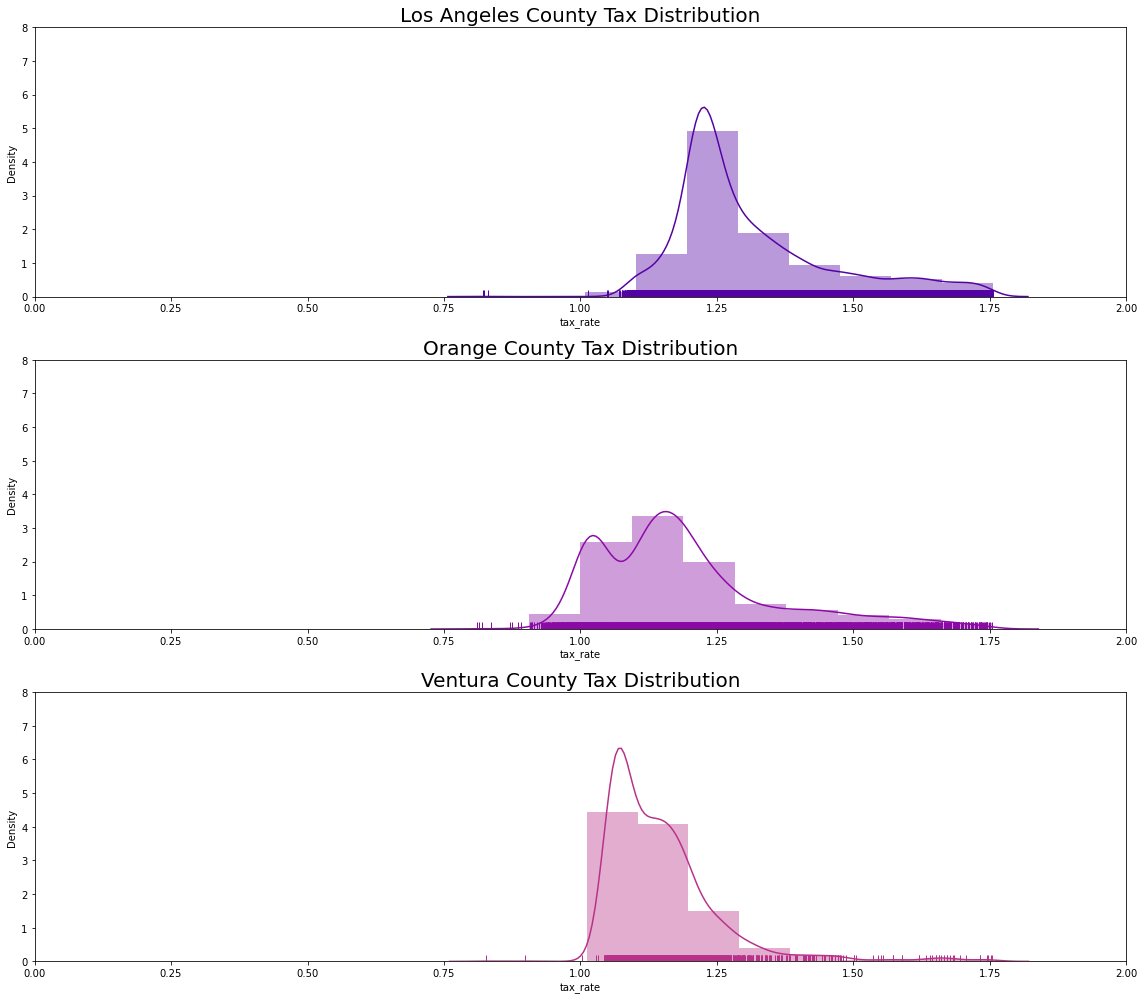

In [76]:
tax_distribution_viz(tax_df)

Text(0.5, 1.0, 'Distributions of Tax Rates by County')

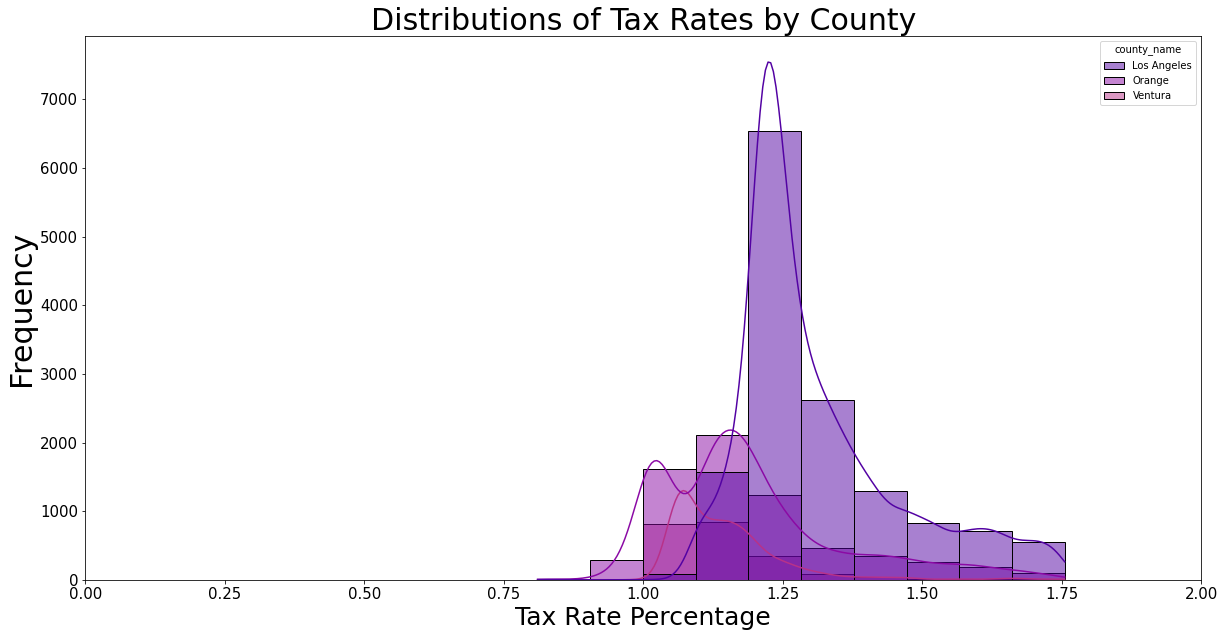

In [77]:
plt.figure(figsize=(20,10))
sns.histplot(data=tax_df, x='tax_rate', kde=True, hue='county_name', bins=10)
plt.xlim(0, 2)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel('Tax Rate Percentage', fontsize=25)
plt.ylabel('Frequency', fontsize=30)
plt.title('Distributions of Tax Rates by County', fontsize=30)

In [78]:
# Tax Rate Distribution Takeaways
- LA county has the most properties

SyntaxError: invalid syntax (<ipython-input-78-eeb7fd3c163f>, line 2)